## 1. 决策树(Decision Trees)

本章将介绍决策树，一种简单而灵活的算法。我们首先将给出决策树的非线性与基于区域的特征，然后对基于区域的损失函数进行定义与对比，最后给出这些方法的优缺点（进而引出集成方法）。

### 1.1 非线性(Non-linearity)

决策树是一种天生支持 **「非线性」** 的机器学习算法。正式来说，如果一个方法是线性的，则其输入 $x \in \mathbb{R}^n$ 会输出下面形式的假设函数：

$$h(x)=\theta^T x$$

其中 $\theta \in \mathbb{R}^n$，截距项内置（$x_0=1$）。

不能被化简为上述形式的假设函数即称为非线性。如果一个方法输出非线性的假设函数，则该方法也为非线性。之前我们介绍了对线性方法引入核函数，通过特征映射可以得到非线性的假设函数。

与核方法相比，决策树则可以直接输出非线性的假设函数。下图给出了基于时间与地点判断该地区能否滑雪的数据：

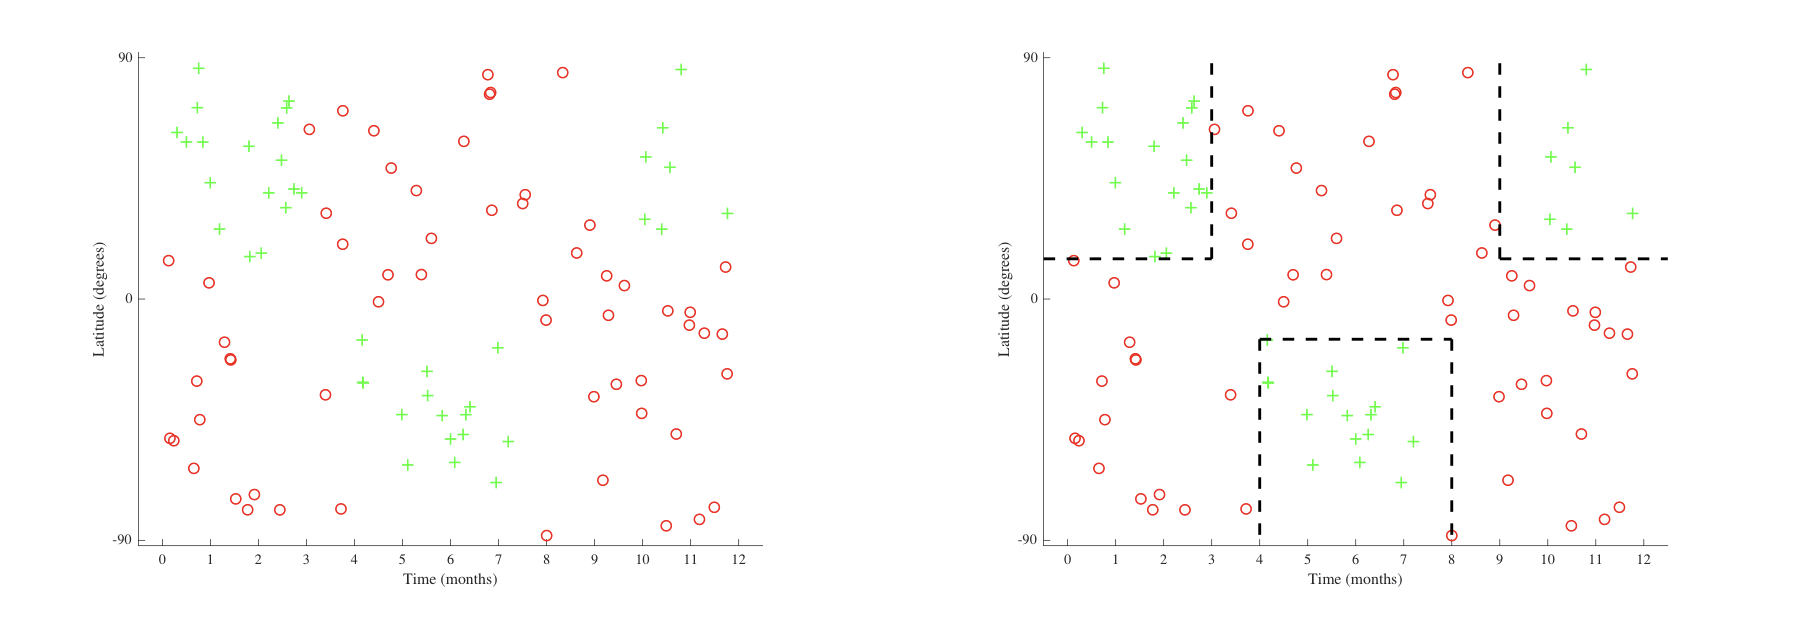

可以看到该数据无法找出线性决策边界，但是我们可以将输入空间 $\chi$ 划分为不同的区域 $R_i$：

$$\chi=\bigcup_{i=1}^n R_i$$

$$\text{s.t.} R_i \cap R_j=\emptyset \text{for}  i \neq j$$

### 1.2 选择区域(Selecting Regions)

一般来说，选择最优的区域是较困难的。决策树通过 **「贪婪、自顶向下，递归的分割」** 来进行区域的选择。

具体来说，我们首先从原始的输入空间 $\chi$ 开始，基于单个特征的某个阈值将其划分为两个子区域，然后再选择其中一个子区域，基于新的阈值进行划分。我们持续以这种递归的方式训练模型：选择 **「叶子节点」（区域）、「特征」** 和 **「阈值」** 来形成一次新的分割。

形式上说，给定一个父区域 $R_p$，一个特征索引 $j$ 和一个阈值 $t\in \mathbb{R}$，我们可以得到如下的两个子区域 $R_1$ 和 $R_2$：

$$R_1=\{X\vert X_j<t,X\in R_p\}$$

$$R_2=\{X\vert X_j \geq t,X\in R_p\}$$

对于之前的滑雪数据集，决策树的执行过程如下图所示：

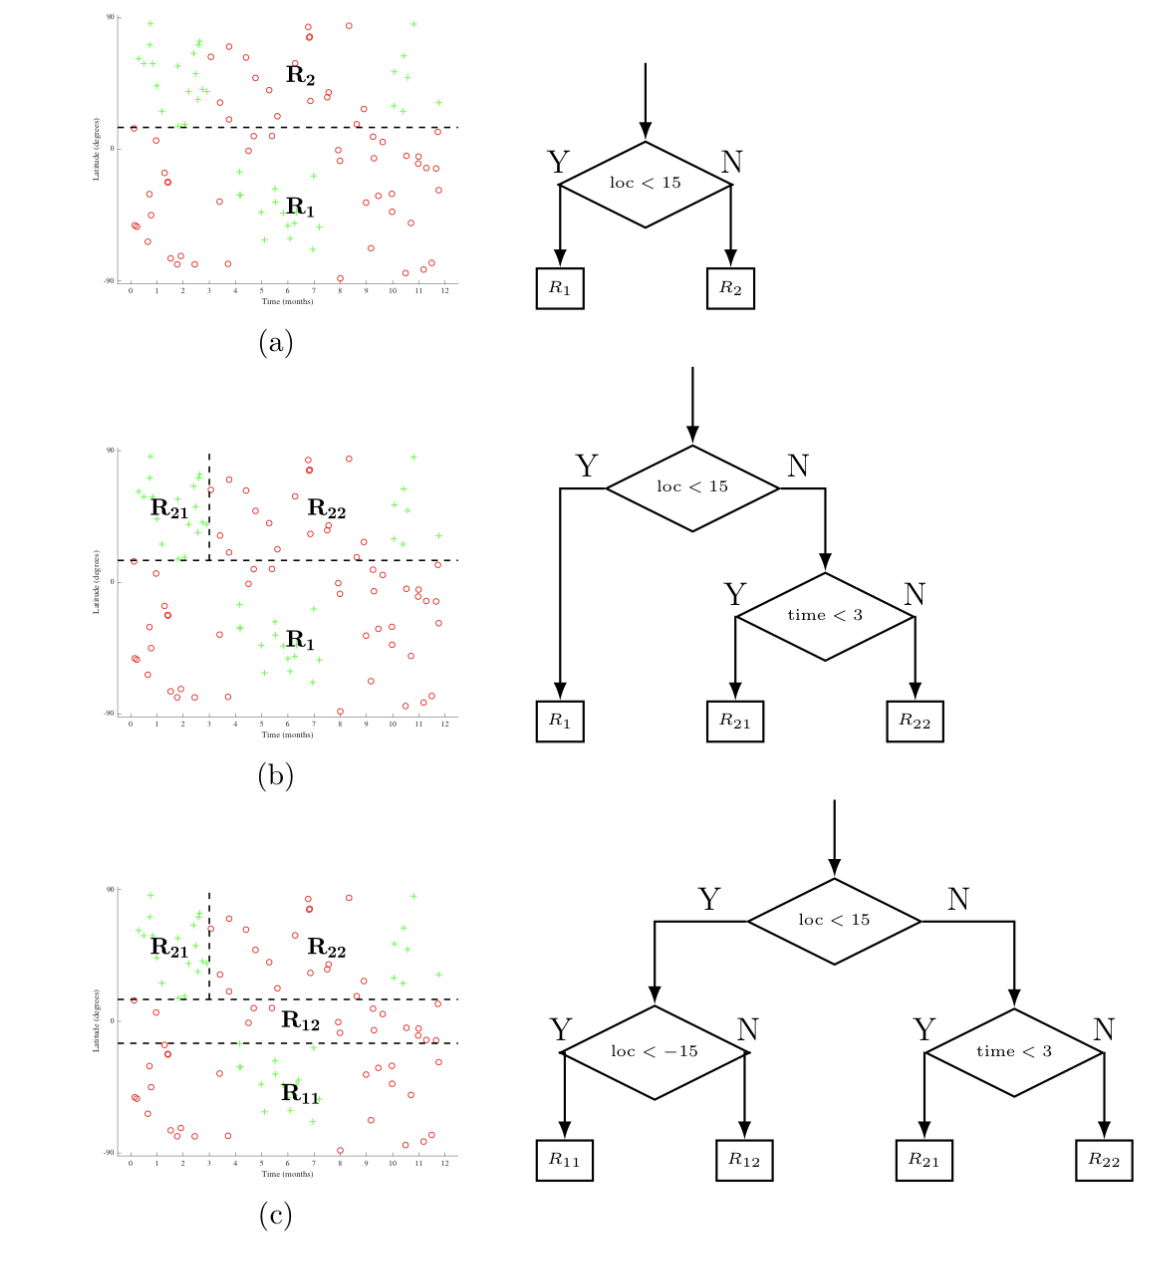

这一过程将持续至满足某个停止条件（之后细说），然后对每个叶子区域预测其所属类别。

### 1.3 Defining a Loss Function

对于上面的过程，一个自然的问题是如何选择 **「分割」**。我们可以基于区域集来定义损失函数 $L$。

给定一个父区域 $R_p$ 和两个子区域 $R_1$ 和 $R_2$，我们可以计算父区域的损失 $L(R_p)$ 和子区域的基数加权损失：

$$\frac{\vert R_1 \vert L(R_1)+\vert R_2 \vert L(R_2)}{\vert R_1 \vert+\vert R_2 \vert}$$

在我们的 **「贪婪」** 分割框架中，我们希望选择区域、特征和阈值来使得损失减少最大化：

$$L(R_p)-\frac{\vert R_1 \vert L(R_1)+\vert R_2 \vert L(R_2)}{\vert R_1 \vert+\vert R_2 \vert}$$

### 1.3.1 错误分类损失

对于一个分类问题，我们感兴趣的是 **「错误分类的损失」** $L_{misclass}$。对于一个区域 $R$，令 $\hat{p}_c$ 为区域中类别为 $c$ 的样本比例，则 $R$ 的错误分类损失可以写作：

$$L_{misclass}=1-\underset{c}{\text{max}}(\hat{p}_c)$$

该公式可以理解为我们将区域中样本数量最多的类作为希望该区域分割出的类别，则剩余的样本即为错误分类的样本。

然而，虽然错误分类损失是分类好坏的最终体现，但其对类别的概率并不敏感。下面的二分类例子体现了这一点：

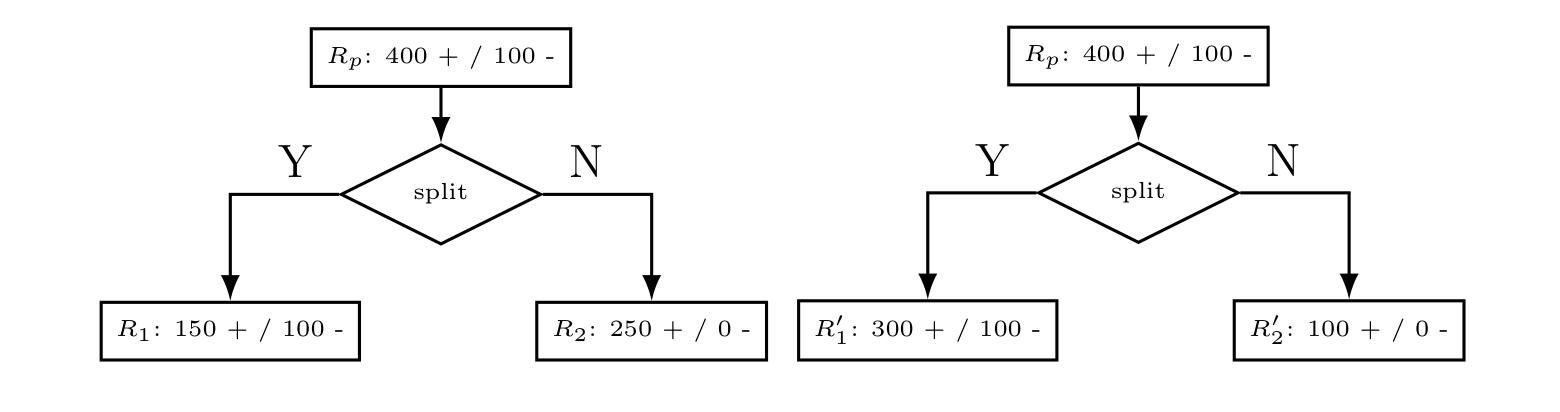

左侧的分割方式可以孤立出更多的正样本，看上去更好，但是：

$$L(R_p)=\frac{\vert R_1 \vert L(R_1)+\vert R_2 \vert L(R_2)}{\vert R_1 \vert+\vert R_2 \vert}=\frac{\vert R_1' \vert L(R_1')+\vert R_2' \vert L(R_2')}{\vert R_1' \vert+\vert R_2' \vert}=\frac{1}{5}$$

可以看到，在错误分类损失函数下，两种分割方式的损失相同，而且也不能降低父区域的损失。

### 1.3.2 交叉熵损失(Cross-entropy)

因此，我们需要定义一个更加敏感的损失函数，这里将使用 **「交叉熵损失」** $L_{cross}$：

$$L_{cross}(R)=-\sum_{c}\hat{p}_c\text{log}_2 \hat{p}_c$$

其中 $\hat{p}\text{log}_2\hat{p} \equiv 0 \text{if} \hat{p}=0$。

从信息论的角度看，交叉熵测量了在分布已知的情况下，为了特定输出所需要的比特的数量。进一步来说，从父区域到子区域的损失的减少可以看做是信息的增加。

为了理解上述两种损失函数之间的敏感性的差别，我们将上面的二分类的例子的损失函数进行作图表述。对于该例，我们可以将损失函数简化为仅依赖于正样本 $\hat{p}_i$ （在区域 $R_i$ 中）

$$L_{misclass}(R)=L_{misclass}(\hat{p})=1-\text{max}(\hat{p},1-\hat{p})$$

$$L_{cross}(R)=L_{cross}(\hat{p})=-\hat{p}\text{log}\hat{p}-(1-\hat{p})\text{log}(1-\hat{p})$$

两个函数的图像如下：

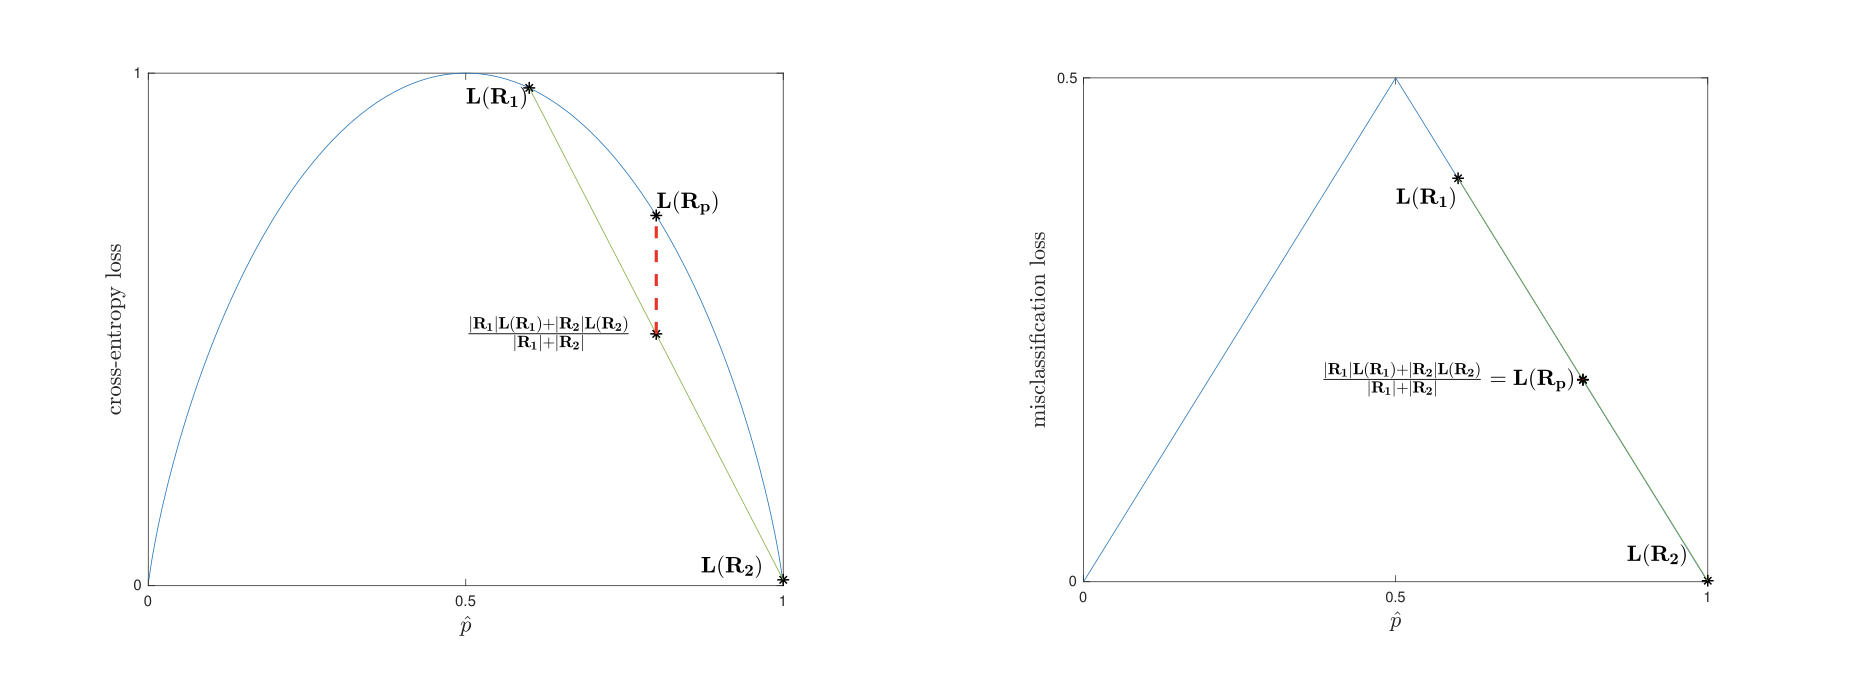

左图对应交叉熵损失函数，右图对应错误分类损失函数，图中的点取自之前例子中左边的分割。

可以看到，因为交叉熵损失严格凹，所以只要 $\hat{p}_1 \neq \hat{p}_2$ 且子区域非空，则其加权损失一定比起父区域的损失要小；而对于右图，由于函数不是严格凹，因此不能保证子区域的加权损失一定小于父区域。

基于这种敏感性，在决策树分类时通常使用交叉熵损失函数。

### 1.3.3 平方损失

对于回归问题，则不能使用上述的损失函数。对每个数据点 $x_i$，我们现在都会有一个对应的值 $y_i \in \mathbb{R}$ 希望去预测。

与分类问题对比，决策树的训练过程大体相同，区别在于对于一个区域 $R$，最终输出为其中所有值的平均：

$$\hat{y}=\frac{\sum_{i\in R}y_i}{\vert R\vert}$$

这种情况下我们可以直接使用 **「平方损失」** 来选择分割：

$$L_{squared}(R)=\frac{\sum_{i \in R}(y_i - \hat{y})^2}{\vert R \vert}$$

### 1.4 其他考量

决策树的流行很大程度上归功于其原理的简单易懂，以及其高度的 **「可解释性」**。我们可以查看生成的阈值集来了解为什么模型作出了该预测。

然而，这并不是决策树的全部，下面将介绍一些关于决策树的值得注意的点。

### 1.4.1 分类变量

决策树的另一个优点是其可以轻松地处理 **「类别」** 变量（指输入）。以之前的滑雪数据为例，将位置变量表示为类别变量（南半球、北半球或赤道）

$$\text{loc} \in \{N,S,E\}$$

其他算法可能需要先进行预处理（如独热编码），将类别变量转化为定量特征，而对于决策树，我们可以直接处理分类变量，如下图所示：

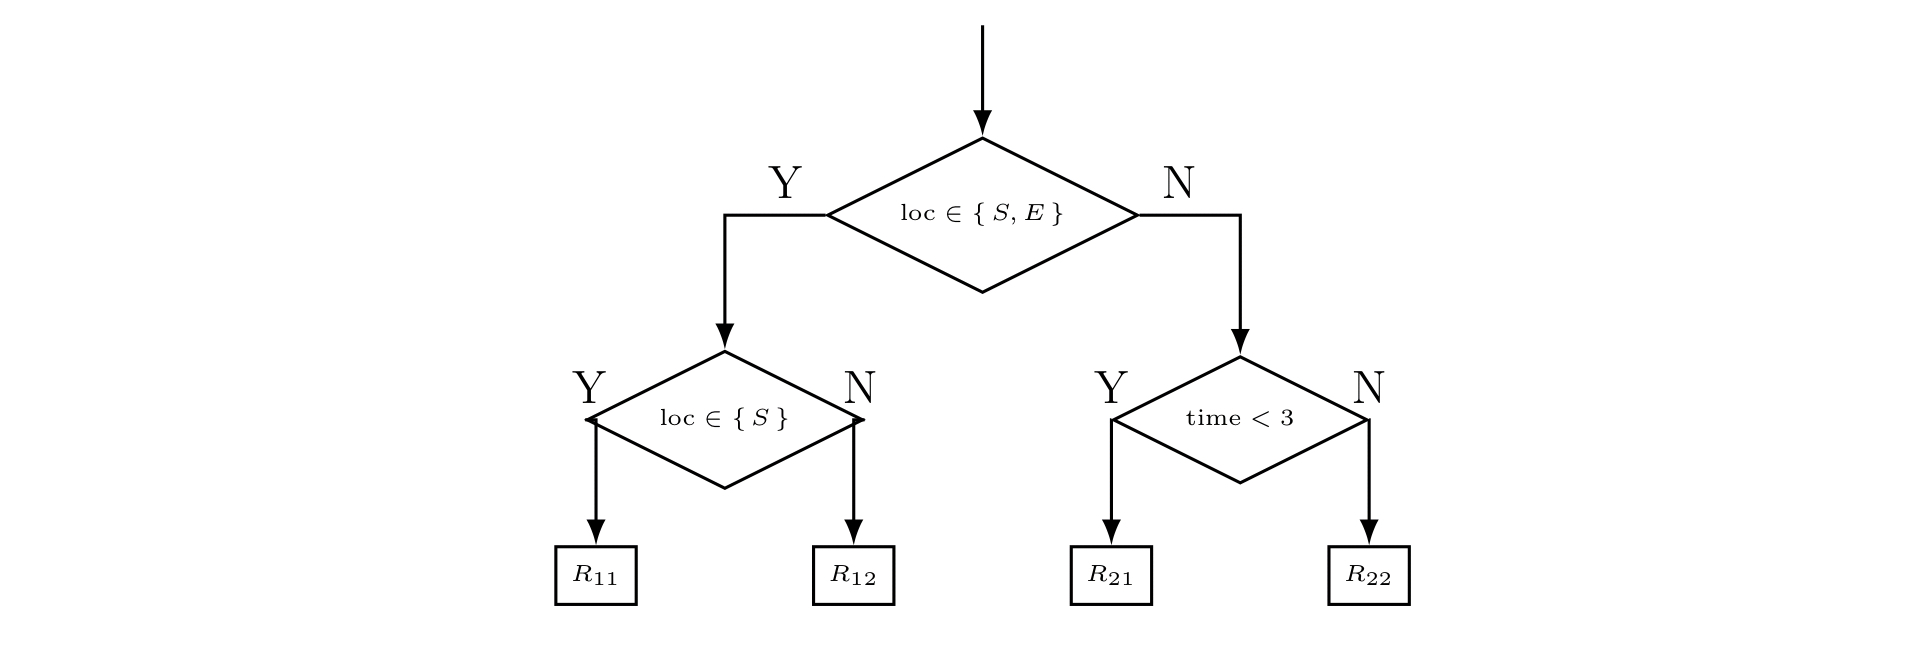

需要注意的是，我们要防止类别过多的情况出现。这会导致计算过于复杂，以及过拟合的出现，这时应该考虑将类别变量进行低维度的定量表达。

### 1.4.2 正则化

之前我们提到了需要一些停止规则来判定何时停止树的生长。最简单的停止规则即为直到每个区域只包含「一个」训练数据点。很明显，这种规则会引起模型的高方差与低偏差（过拟合）。

我们需要一些启发性的停止规则来进行正则化，常用的规则包括：

* 「最小化叶子规模」：当区域的基数低于某个阈值时，停止分割该区域

* 「最小化深度」：如果某个区域进行的分割次数超过了某个阈值，则停止分割

* 「最小化节点数量」：当一个树拥有了超过某个阈值的叶子节点，则停止生长

除了上述规则外，还可能想到的一个启发式规则是使得每次切分后的损失降低最小。但这种方法是存在问题的，因为决策树是基于单个特征的贪婪算法，可能导致遗失某些高阶的互动。

如果基于多个特征设定阈值来获得更好的分割，则可能难以在初期的分割中获得较好的损失下降，最终导致算法过早地终止（这里不太懂笔记里的意思，我的理解是这个规则和之前最大化损失降低的原则相违背）。

还有一种较好的方法是将树完全生长出来，然后基于验证集修剪那些使得错误分类或平方误差减少最小的叶子节点。

### 1.4.3 运行时间

下面简单介绍决策树的 **「运行时间」**。为了简化分析，这里考虑二元分类问题，其中包含 $n$ 个样本、$f$ 个特征以及一个深度为 $d$ 的树。

在测试时，对于一个样本点，我们搜索树直到一个叶子节点，然后输出预测，运行时间为 $O(d)$。如果我们的树是平衡的，则 $d=O(\text{log}n)$，这种情况下，测试时间一般来说是相当快的。

在训练时，每个数据点最多只会在 $O(d)$ 个节点中出现，通过排序和对中间值的智能缓存，我们可以使得针对每个节点的每个数据点的每个特征，其分摊运行时间为 $O(1)$。因此，总的运行时间为 $O(nfd)$，对于一个维数为 $n\times f$ 的数据矩阵来说，这是一个相当快的运行时间。

### 1.4.4 加性结构的缺失

决策树的一个缺点是其不能轻易地捕捉 **「加性结构」**。在下面的例子中，决策树每一次分割只能考虑一个特征，而线性模型则可以直接导出右图所示的边界：

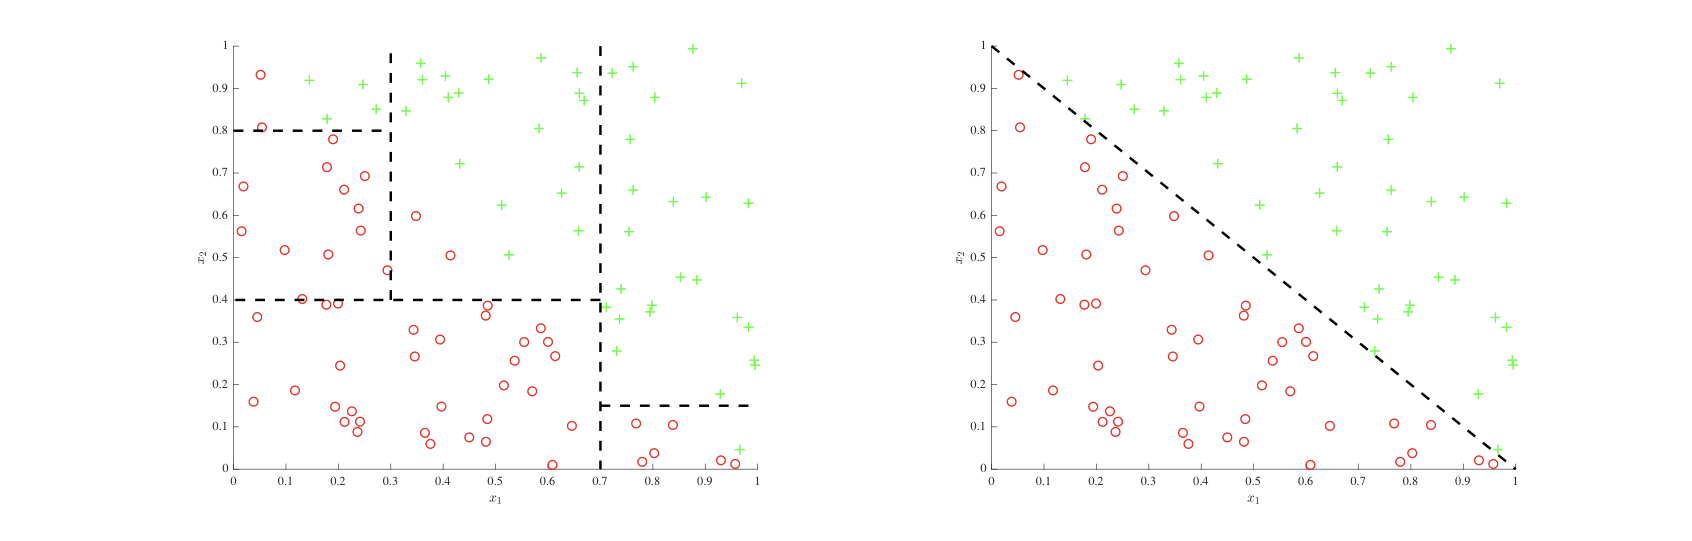

一些研究对决策树进行了改进使其能够同时考虑多个特征，但还是存在增加方差和减少可解释性的缺点。

### 1.5 总结

决策树的主要优点是：

* 易于理解

* 可解释性

* 支持分类变量

* 速度快

决策树的缺点包括：

* 高方差

* 对加性模型的建模支持较差

上述缺点会导致单个决策树的整体预测准确率较低，解决这个问题的常见方法是使用「集成学习」。

## 2. 集成方法(Ensembling Method)

集成方法就是将多个训练模型的输出结合起来，我们将使用 **「偏差-方差」** 分析以及以决策树为例来探究集成方法的利弊。

首先，让我们用一个基础概率论的例子证明集成方法的优势所在。假设我们有 $n$ 个独立同分布的随机变量 $X_i$。假定对于所有 $X_i$ 均有 $\mathbb V \text{ar}(X_i)=\sigma^2$.

则平均值的方差为：

$$\mathbb V \text{ar}(\bar{X})=\mathbb V \text{ar}(\frac{1}{n}\sum_{i}X_i)=\frac{\sigma^2}{n}$$

如果我们抛弃了独立假设，即变量仅为同分布。相对地，$X_i$ 之间的关联系数为 $\rho$，则平均值的方差为：

$$\begin{align*}
        \mathbb V \text{ar}(\bar{X})
        &=\mathbb V \text{ar}(\frac{1}{n}\sum_{i}X_i)\\
        & = \frac{1}{n^2} \sum_{i,j} \text{Cov}(X_i,X_j)\\
                      & = \frac{n\sigma^2}{n^2}+\frac{n(n-1)\rho \sigma^2}{n^2} \\
                      & = \rho \sigma^2 +\frac{1-\rho}{n}\sigma^2
\end{align*}$$

在第三步中，使用了皮尔逊相关系数的定义 $\rho_{X,Y}=\frac{\text{Cov}(X,Y)}{\sigma_x \sigma_y}$ 以及 $\text{Cov}(X,X)=\mathbb{V}\text{ar}(X)$。

现在，如果我们将每个随机变量想象为一个给定模型的误差，则增加模型数量以及降低模型之间的相关性都可以减少集成后的模型误差的方差：

* 增加模型数量减少第二项的值

* 降低模型之间的相关性减少第一项的值，使得各变量回归独立同分布

生成不相关的模型的方法有很多种，包括：

* 使用不同的算法

* 使用不同的训练集

* 装袋法（Bagging）

* 提升法（Boosting）

实际上提升法并不会降低模型之间的相关性（此处是笔记的一个矛盾点）。虽然前两种方法很直接，但其需要较大的工作量，下面将介绍后两种方法：**「装袋法」** 与 **「提升法」**，以及他们在决策树中的特殊应用。

### 2.1 装袋法

Bagging 代表 Bootstrap Aggregation，是一种 **「减少方差」** 的集成方法。

#### 2.1.1 自助（Bootstrap）

自助法是一种来源于统计学的方法，其最初的目的是测量某些估计量（如均值）的不确定性。

假定我们有一个总体 $P$，希望去计算其的某个估计量，以及一个采样自 $P$ 的训练集 $S$（$S\sim P$）。虽然我们可以通过计算 $S$ 的估计量来近似 $P$ 的估计量，但我们无法得知其与真实值的误差。为了做到这一点我们需要采样自 $P$ 的多个独立训练集 $S_1, S_2,\cdots$。

自助法的思路是假设 $S=P$，则我们可以生成一个新的 bootstrap 集 $Z$ 采样自 $S$（$Z \sim S,\vert Z \vert=\vert S \vert$），进而生成多个这样的样本 $Z_1,Z_2,\cdots,Z_M$，然后通过这些自助集上的估计量的方差来得到对误差的估计.

#### 2.1.2 聚合（Aggregation）

对于集成方法，我们可以用每个样本 $Z_m$ 去训练一个机器学习模型 $G_m$，然后定义如下的聚合模型：

$$G(X)=\sum_m \frac{G_m(x)}{M}$$

这一过程即称为 **「bagging」**。在之前的推导中，我们得出 $M$ 个相关模型的方差为：

$$\mathbb{V}\text{ar}(\bar{X})=\rho \sigma^2+\frac{1-\rho}{M}\sigma^2$$

bagging 通过在不同数据集上训练模型来减少模型之间的关联性 $\rho$ 。

虽然单个模型的偏差会增加因为其没有使用全部训练集，但是方差的减少弥补了偏差增加的影响。此外，增加模型的数量并不会导致额外的过拟合，因为 $\rho$ 对 $M$ 不敏感，因此总体方差只会下降。

bagging 的另外一个好处是 **「袋外估计」（out-of-bag estimation）**。可以证明每个 bootstrap 样本都只包含大概 $\frac{2}{3}$ 的样本，因此可以用剩下的 $\frac{1}{3}$ 样本来进行误差估计，称为袋外误差。在极限情况下，$M\rightarrow \infty$，袋外误差就等价于留一交叉验证。

#### 2.1.3 装袋法 + 决策树

完全生长的决策树具有高方差、低偏差的特点，因此 bagging 降低方差的效果可以很好的弥补上述不足。此外，bagging 还可以处理缺失特征，如果一个特征有缺失，则排除在分割中使用到该特征的树。不过当该特征是重要的预测依据时，它仍然会保留在大部分的树中。

袋装决策树的一个缺点是失去了单个决策树的内在可解释性。我们可以通过一种叫 **「变量重要性测量」** 的方法来一定程度上恢复模型的洞察力，对于每个特征，找出在集成中使用到该特征的每一个分割，并将所有这些分割导致的损失函数的降低进行平均。注意这种方法与衡量缺少该特征会引起多少性能下降有所不同，因为这些分割中也包含了其他特征。

关于袋装决策树的最后一个重要内容是 **「随机森林」** 方法。如果我们的数据集包含了一个非常强的预测器（特征），则我们的袋装树总会使用该特征来进行分割，导致了模型之间的关联性上升。而随机森林算法中，每次分割我们只允许使用特征的一个子集，这样可以降低关联性 $\rho$，从而导致方差的下降。这种方法同时也会导致偏差的上升，由于对特征空间的限制，但是与常规的袋装决策树一样这并不会有什么影响。最终，即便是非常有用的特征也不会出现在每个树中（假设树的数量足够且每次分割对特征有充分的限制），这种方法同时还能更优雅地处理缺失特征。

### 2.1.4 总结

对于决策树，装袋法的主要优点有：

* 降低方差（决策森林更加显著）

* 更好的准确性

* 自由的验证集

* 支持缺失值

其缺点包括：

* 偏差的增加（决策森林更加显著）

* 可解释性差

* 依然缺乏加性

* 计算成本更高

### 2.2 提升法

#### 2.2.1 直观理解

装袋法是一种降低方差的技术，而提升法则是一种 **「降低偏差」** 的技术。因此，我们需要高偏差低方差的模型来使用提升法，这种模型即「弱学习模型」（weak learners）。

对决策树来说，通过只允许每个树在预测前进行一次决策，可以将其变为弱学习模型，这种决策树也称为「决策树桩」（decision stumps）。

我们将以下图为例介绍提升法的思想，原始数据集如最左侧的图所示：

